# FINM3422 Coding Project 2: OTC Derivatives Pricing & Hedging

This notebook implements an object-oriented solution to value four OTC derivative trades and calculate portfolio-level hedging parameters. All data and valuations including spot prices, volatilities and time to maturity is based on market data as of May 16. Each derivative is modelled using an appropriate valuation method (e.g. Black-Scholes) to reflect key financial principles. The project's requirements are met by combining Object Oriented programming with realistic market integration to achieve accurate pricing and risk assessment in a way that resembles real world trading and risk management practices.

## Imports and Setup

In [26]:
from Option_Classes import EuropeanOption
from Option_Classes import AmericanPutOption
from Option_Classes import UpAndInCallOption
from Option_Classes import BasketCallOption
from Hedging_Parameters import HedgingCalculator
from market_data import get_close_price
from market_data import get_volatility
from market_data import get_correlation_matrix
from market_data import get_all_market_data
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import importlib
from visualise import plot_spot_vol_sensitivity, plot_spot_vol_sensitivity_barrier, plot_spot_vol_sensitivity_basket_bs # update
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

## Discount Curve Construction

do we build discount curve in the .ipynb file, or can we just produce the discount rates in the .py file? fix with the new discount curve file

In [92]:
from bootstrap import BankBill, Bond, Portfolio, YieldCurve
def time_to_expiry(start, end):
    return (end - start).days / 365.0

# Bootstrap yield curve based off of bills and bonds
# Data extracted from bloomberg terminal
if __name__ == "__main__":

    # 1 Month Bank Bill

    maturity_1m = 1 / 12  # 1 month = 1/12 year
    yield_1m = 3.7925 / 100
    price_1m = 100 * (1 - yield_1m * maturity_1m)  # ≈ 99.684

    bill1 = BankBill(face_value=100, maturity=1/12, price=99.684)
    bill1.set_cash_flows()

    # 3 Month Bank Bill

    maturity_3m = 0.25  # 3 months
    yield_3m = 3.7972 / 100
    price_3m = 100 * (1 - yield_3m * maturity_3m)  # ≈ 99.055

    bill2 = BankBill(face_value=100, maturity=0.25, price=99.055)
    bill2.set_cash_flows()

    # 6 Month Bank Bill

    maturity_6m = 0.5  # 6 months
    yield_6m = 3.8550 / 100
    price_6m = 100 * (1 - yield_6m * maturity_6m)  # ≈ 98.083

    bill3 = BankBill(face_value=100, maturity=0.5, price=98.083)
    bill3.set_cash_flows()

    # Longer Term Bond Data

    bond1 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2025, 11, 21)), coupon=0.0025, frequency=2, price=98.369)
    bond1.set_cash_flows()

    bond2 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2026, 4, 21)), coupon=0.0425, frequency=2, price=101.134)
    bond2.set_cash_flows()

    bond3 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2026, 9, 21)), coupon=0.005, frequency=2, price=96.420)
    bond3.set_cash_flows()

    bond4 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2027, 4, 21)), coupon=0.0475, frequency=2, price=103.141)
    bond4.set_cash_flows()

    bond5 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2027, 11, 21)), coupon=0.0275, frequency=2, price=98.773)
    bond5.set_cash_flows()

    bond6 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2028, 5, 21)), coupon=0.0225, frequency=2, price=96.874)
    bond6.set_cash_flows()

    bond7 = Bond(face_value=100, maturity= time_to_expiry(datetime(2025, 5, 16), datetime(2028, 11, 21)), coupon=0.0275, frequency=2, price=98.040)
    bond7.set_cash_flows()

    # Step 2: Add to portfolio
    portfolio = Portfolio()
    portfolio.add_bank_bill(bill1)
    portfolio.add_bank_bill(bill2)
    portfolio.add_bank_bill(bill3)
    portfolio.add_bond(bond1)
    portfolio.add_bond(bond2)
    portfolio.add_bond(bond3)
    portfolio.add_bond(bond4)
    portfolio.add_bond(bond5)
    portfolio.add_bond(bond6)
    portfolio.add_bond(bond7)


    # Step 3: Build curve
    yc = YieldCurve()
    yc.bootstrap(portfolio)



## Trade 1: BHP European Call

The below trade is a long European call option on BHP Group Ltd (BHP) which is struck at 38.93 and expiring on the 15th September 2027. This option is valued using the Black-Scholes model based on market conditions as of 16th May 2025 including a BHP spot price of $39.72, implied volatility of 29.67% and a risk free interest rate of 5.59%. Thus, this trade positions the buyer with leveraged upside exposure to BHP  with limited downside risk

### Market Data

In [93]:
# Extract relevant data for option pricing and hedging
ticker_bhp = "BHP.AX"
date = "2025-05-16"

spot_bhp = get_close_price(ticker_bhp, date) #good
vol_bhp = get_volatility(ticker_bhp, end_date=date, window=60) #good
strike_bhp = 0.98 * spot_bhp

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_bhp = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years



print(f"Spot Price: {spot_bhp}, Volatility: {vol_bhp}, Strike Price: {strike_bhp}, Expiry: {expiry_bhp} years")


## remove the extra shit and make scalars, also build so that it extracts only the correlation matrix?

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Spot Price: 39.720001220703125, Volatility: 0.2960193441890185, Strike Price: 38.925601196289065, Expiry: 2.334246575342466 years


### Discount Rate

In [94]:
# Given the time to expiry, find the discount factor and zero rate
rate_bhp = yc.get_zero_rate(expiry_bhp)
print(f"Rate for BHP Option: {rate_bhp:.4%}")



Rate for BHP Option: 5.0330%


### Valuation

In [95]:
# Instantiate and price the option 
dividend_yield_bhp = 0.04329 
bhp_option = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp, expiry=expiry_bhp, rate=rate_bhp, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

print(f"Option Price: {bhp_option.price()}")

Option Price: 6.973563901310838


### Visualisation

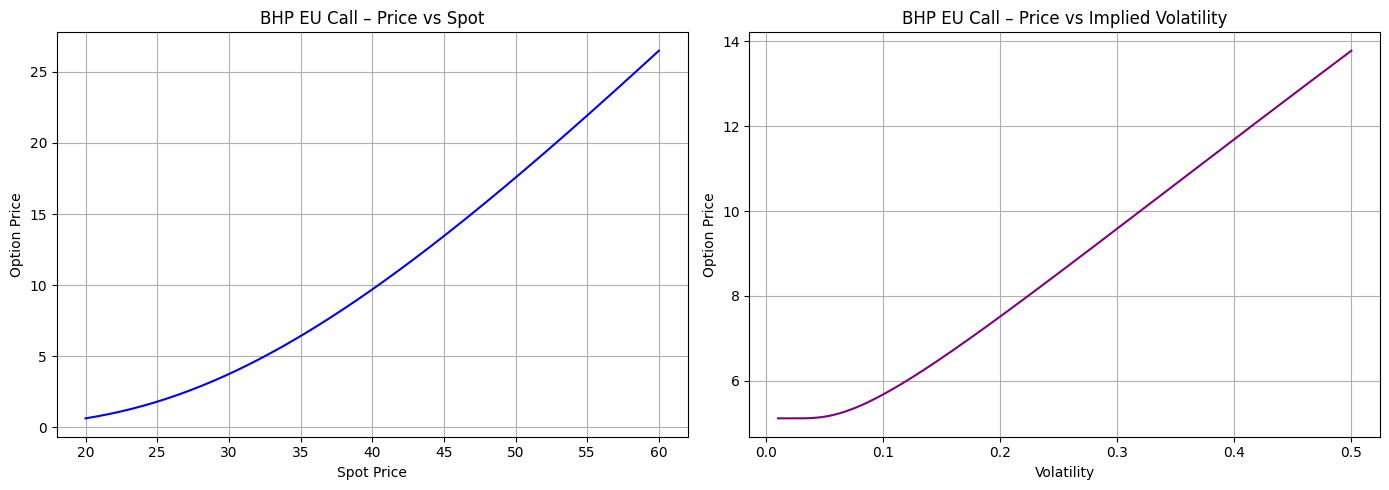

In [96]:
from visualise import plot_spot_vol_sensitivity

plot_spot_vol_sensitivity(option_class=EuropeanOption, label = "BHP EU Call", base_spot=spot_bhp, base_vol=vol_bhp, spot_range=(20,60,200), vol_range=(0.01,0.5,200), ticker=ticker_bhp, strike=strike_bhp, expiry=expiry_bhp, rate=rate_bhp, option_type="call")


### Hedging Parameters

In [8]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho

hc = HedgingCalculator()
greeks_bhp = hc.get_all_greeks(bhp_option, method="fd")

print("Greeks for BHP Option:")
for greek, value in greeks_bhp.items():
    print(f"{greek}: {value}")





Greeks for BHP Option:
delta: 0.5609804551034436
gamma: 0.019148641090538376
vega: 20.874573140622665
theta: 1.1303454519737954
rho: 35.73400201266175


### Hedging Strategy

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Near-the-money option
strike_bhp_ntmo = spot_bhp
expiry_bhp_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years
rate_bhp_ntmo = yc.get_zero_rate(expiry_bhp_ntmo)
bhp_option_ntmo = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp_ntmo, expiry=expiry_bhp_ntmo, rate=rate_bhp_ntmo, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

delta_ntmo = hc.calculate_delta_fd(bhp_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(bhp_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(bhp_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(bhp_option_ntmo)

# Out-the-money option
strike_bhp_otmo = 0.9 * spot_bhp
expiry_bhp_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years
rate_bhp_otmo = yc.get_zero_rate(expiry_bhp_otmo)
bhp_option_otmo = EuropeanOption(ticker=ticker_bhp, spot=spot_bhp, strike=strike_bhp_otmo, expiry=expiry_bhp_otmo, rate=rate_bhp_otmo, vol=vol_bhp, option_type="call", dividend_yield=dividend_yield_bhp)

delta_otmo = hc.calculate_delta_fd(bhp_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(bhp_option_otmo)
vega_otmo = hc.calculate_vega_fd(bhp_option_otmo)
rho_otmo = hc.calculate_rho_fd(bhp_option_otmo)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Option": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Option": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
}

# Create a hedge matrix
hedge_matrix = pd.DataFrame(hedges).T

print("Hedge Matrix:")
print(hedge_matrix)

# Calculate the current Greeks of the BHP option
delta = hc.calculate_delta_fd(bhp_option)
gamma = hc.calculate_gamma_fd(bhp_option)
vega = hc.calculate_vega_fd(bhp_option)
rho = hc.calculate_rho_fd(bhp_option)

# Define the current Greeks of the BHP option
bhp_greeks = np.array([
    hc.calculate_delta_fd(bhp_option),
    hc.calculate_gamma_fd(bhp_option),
    hc.calculate_vega_fd(bhp_option),
    hc.calculate_rho_fd(bhp_option)
])

# Define the optimization function
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + bhp_greeks)  # Minimize the difference

# Initial guess (equal weights)
initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)

# Solve for optimal hedge weights
result = minimize(objective, initial_weights)

# Display results
optimal_weights = result.x
hedge_allocations = pd.DataFrame({"Instrument": hedge_matrix.index, "Optimal Weight": optimal_weights})
print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

# Visualize the new greeks after hedging
minimized_greeks = hedge_matrix.values.T @ optimal_weights + bhp_greeks

greek_names = ["Delta", "Gamma", "Vega", "Rho"]
greek_matrix = pd.DataFrame({
    "Original BHP Option": bhp_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                          Delta     Gamma       Vega        Rho
Underlying Stock       1.000000  0.000000   0.000000   0.000000
Near-the-Money Option  0.545514  0.019394  21.141903  35.014711
Out-the-Money Option   0.623548  0.017755  19.354708  38.374880

Optimal Hedge Allocations:
              Instrument  Optimal Weight
0       Underlying Stock          0.0005
1  Near-the-Money Option         -0.8190
2   Out-the-Money Option         -0.1839

Greek Neutralization Result:
       Original BHP Option  Post-Hedging (Minimized)
Delta               0.5610                      -0.0
Gamma               0.0191                      -0.0
Vega               20.8746                      -0.0
Rho                35.7340                      -0.0


### Design and Model Justification

** DISCUSS why black-scholes and other factors and why we chose to do x in this trade. (Refer to marking rubric on justifcation of models chosen, need to hit high distinction band)

## Trade 2: CBA American Put

description of the trade

### Market Data

In [14]:
ticker_cba = "CBA.AX"
date = "2025-05-16"

spot_cba = get_close_price(ticker_cba, date)
vol_cba = get_volatility(ticker_cba, end_date=date, window=60)
strike_cba = 170.00

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_cba = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15)) # 1 Year


print(f"Spot Price: {spot_cba}, Volatility: {vol_cba}, Strike Price: {strike_cba}, Expiry: {expiry_cba} years")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Spot Price: 169.66000366210938, Volatility: 0.26622126099171345, Strike Price: 170.0, Expiry: 0.9972602739726028 years


### Discount Rate

In [75]:
# Instantiate and price the option
rate_cba = yc.get_zero_rate(expiry_cba)
print(f"Rate for CBA Option: {rate_cba:.4%}")

Rate for CBA Option: 2.6061%


### Valuation

In [16]:
# Instantiate and price the option 
dividend_yield_cba = 0.02867  
cba_option = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, vol=vol_cba, option_type="put", steps=10, dividend_yield=dividend_yield_cba)
print(f"Option Price: {cba_option.price()}")

Option Price: 17.56109341474462


### Visualisation

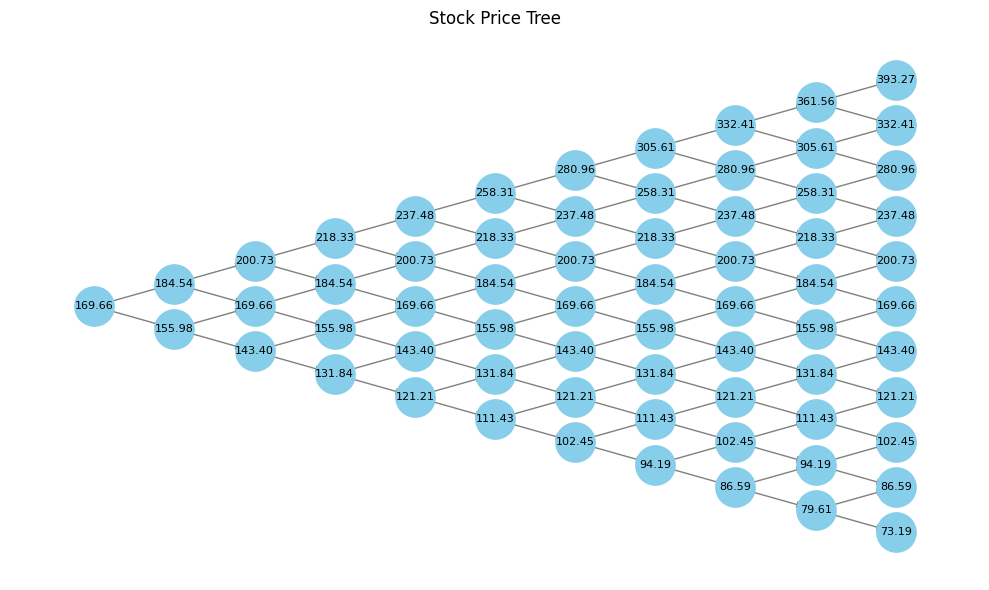

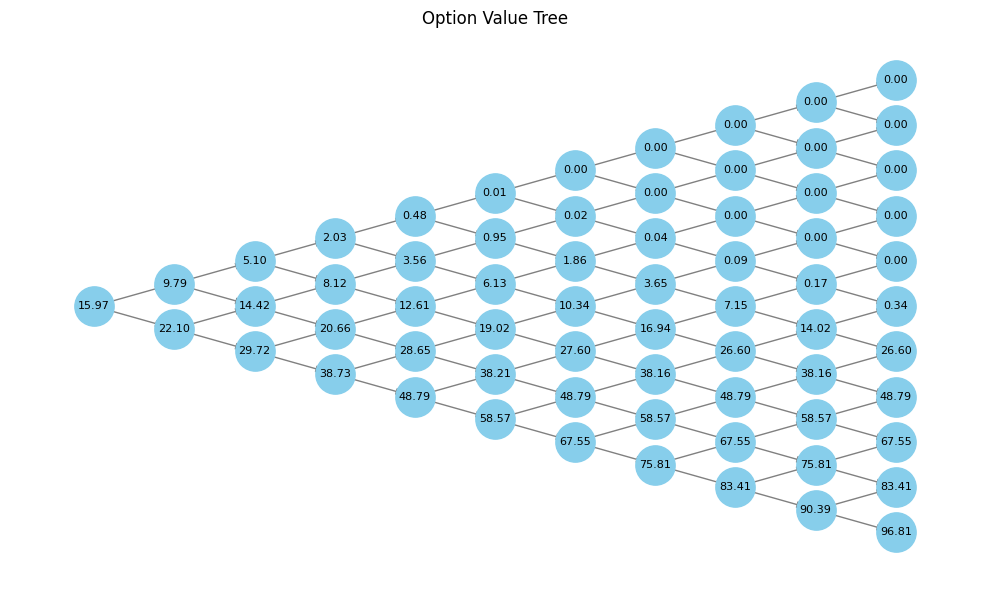

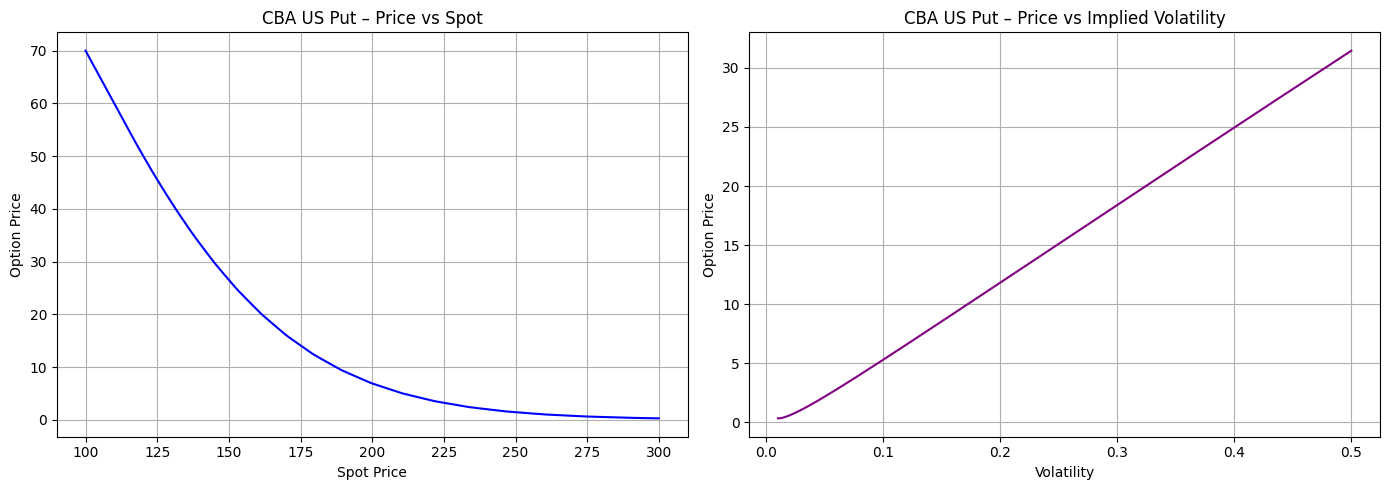

In [17]:
import tree_visualiser
importlib.reload(tree_visualiser)
from tree_visualiser import get_stock_and_option_trees, plot_binomial_tree_networkx
spot = spot_cba
strike = strike_cba
expiry = expiry_cba
rate = rate_cba
vol = vol_cba
steps = 10

stock_tree, option_tree = get_stock_and_option_trees(spot, strike, expiry, rate, vol, steps)

plot_binomial_tree_networkx(stock_tree, title="Stock Price Tree")
plot_binomial_tree_networkx(option_tree, title="Option Value Tree")



plot_spot_vol_sensitivity(option_class=AmericanPutOption, label = "CBA US Put", base_spot=spot_cba, base_vol=vol_cba, spot_range=(100,300,200), vol_range=(0.01,0.5,200), ticker=ticker_cba, strike=strike_cba, expiry=expiry_cba, rate=rate_cba, option_type="put")




### Hedging Parameters

In [18]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_cba = hc.get_all_greeks(cba_option, method="fd")

print("Greeks for CBA Option:")
for greek, value in greeks_cba.items():
    print(f"{greek}: {value}")

Greeks for CBA Option:
delta: -0.5608080475315802
gamma: 7.105427357601002e-11
vega: 64.1575099840045
theta: 8.405882102389583
rho: -71.80746886731981


### Hedging Strategy

In [76]:
# Near-the-money option
strike_cba_ntmo = spot_cba
expiry_cba_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15)) # 1 Year
rate_cba_ntmo = yc.get_zero_rate(expiry_cba_ntmo)
cba_option_ntmo = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba_ntmo, expiry=expiry_cba_ntmo, rate=rate_cba_ntmo, vol=vol_cba, option_type="put", dividend_yield=dividend_yield_cba)

delta_ntmo = hc.calculate_delta_fd(cba_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(cba_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(cba_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(cba_option_ntmo)

# Out-the-money option
strike_cba_otmo = 185.00
expiry_cba_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 1 Year
rate_cba_otmo = yc.get_zero_rate(expiry_cba_otmo)
cba_option_otmo = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba_otmo, expiry=expiry_cba_otmo, rate=rate_cba_otmo, vol=vol_cba, option_type="put", dividend_yield=dividend_yield_cba)

delta_otmo = hc.calculate_delta_fd(cba_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(cba_option_otmo)
vega_otmo = hc.calculate_vega_fd(cba_option_otmo)
rho_otmo = hc.calculate_rho_fd(cba_option_otmo)

# Short-term option
strike_cba_st = 170.00
expiry_cba_st = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 8, 15)) # 3 Months
rate_cba_st = yc.get_zero_rate(expiry_cba_st)
cba_option_st = AmericanPutOption(ticker=ticker_cba, spot=spot_cba, strike=strike_cba_st, expiry=expiry_cba_st, rate=rate_cba_st, vol=vol_cba, option_type="put", dividend_yield=dividend_yield_cba)

delta_st = hc.calculate_delta_fd(cba_option_st)
gamma_st = hc.calculate_gamma_fd(cba_option_st)
vega_st = hc.calculate_vega_fd(cba_option_st)
rho_st = hc.calculate_rho_fd(cba_option_st)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Option": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Option": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
    "Short-Term Option": {"Delta": delta_st, "Gamma": gamma_st, "Vega": vega_st, "Rho": rho_st},
}

# Create a hedge matrix
hedge_matrix = pd.DataFrame(hedges).T

print("Hedge Matrix:")
print(hedge_matrix)

# Calculate the current Greeks of the CBA option
delta = hc.calculate_delta_fd(cba_option)
gamma = hc.calculate_gamma_fd(cba_option)
vega = hc.calculate_vega_fd(cba_option)
rho = hc.calculate_rho_fd(cba_option)

# Define the current Greeks of the CBA option
cba_greeks = np.array([
    hc.calculate_delta_fd(cba_option),
    hc.calculate_gamma_fd(cba_option),
    hc.calculate_vega_fd(cba_option),
    hc.calculate_rho_fd(cba_option)
])

# Define the optimization function
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + cba_greeks)  # Minimize the difference

# Initial guess (equal weights)
initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)

# Solve for optimal hedge weights
result = minimize(objective, initial_weights)

# Display results
optimal_weights = result.x
hedge_allocations = pd.DataFrame({"Instrument": hedge_matrix.index, "Optimal Weight": optimal_weights})
print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

# Visualize the new Greeks after hedging
minimized_greeks = hedge_matrix.values.T @ optimal_weights + cba_greeks

greek_names = ["Delta", "Gamma", "Vega", "Rho"]
greek_matrix = pd.DataFrame({
    "Original CBA Option": cba_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                          Delta         Gamma       Vega         Rho
Underlying Stock       1.000000  0.000000e+00   0.000000    0.000000
Near-the-Money Option -0.442352  7.354972e+00  65.393147  -78.553856
Out-the-Money Option  -0.501221  2.131628e-10  94.891173 -157.260529
Short-Term Option     -0.504538  5.329071e-11  33.434678  -18.625584

Optimal Hedge Allocations:
              Instrument  Optimal Weight
0       Underlying Stock         -0.0858
1  Near-the-Money Option         -0.0000
2   Out-the-Money Option         -0.3455
3      Short-Term Option         -0.9384

Greek Neutralization Result:
       Original CBA Option  Post-Hedging (Minimized)
Delta              -0.5608                       0.0
Gamma               0.0000                      -0.0
Vega               64.1575                      -0.0
Rho               -71.8075                       0.0


### Design and Model Justification

## Trade 3: WES Barrier Call

description of the trade

### Market Data

In [77]:
ticker_wes = "WES.AX"
date = "2025-05-16"

spot_wes = get_close_price(ticker_wes, date) #good
vol_wes = get_volatility(ticker_wes, end_date=date, window=60) #good
strike_wes = 80
barrier_wes = 100

def time_to_expiry(start, end):
    return (end - start).days / 365.0

expiry_wes = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15)) # 2.33 Years

print(f"Spot Price: {spot_wes}, Volatility: {vol_wes}, Strike Price: {strike_wes}, Expiry: {expiry_wes} years, Barrier: {barrier_wes}")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Spot Price: 82.55999755859375, Volatility: 0.21930636472137627, Strike Price: 80, Expiry: 2.334246575342466 years, Barrier: 100


### Discount Rate

In [81]:
rate_wes = yc.get_zero_rate(expiry_wes) 
print(f"Rate for WES Option: {rate_wes:.4%}")

Rate for WES Option: 5.0330%


### Valuation

In [23]:
# Instantiate and price the option 
dividend_yield_wes = 0.02762
wes_option = UpAndInCallOption(ticker=ticker_wes, spot=spot_wes, strike=strike_wes, expiry=expiry_wes, rate=rate_wes, vol=vol_wes, barrier=barrier_wes, simulations=10000, steps=252, dividend_yield=dividend_yield_wes)
print(f"Option Price: {wes_option.price()}")

Option Price: 13.124196639431865


### Visualisation

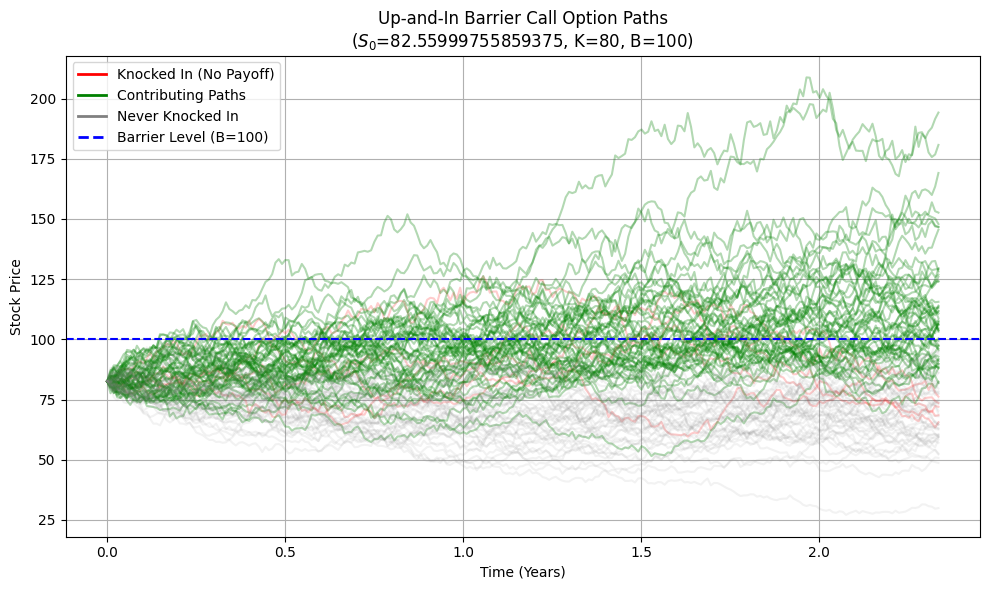

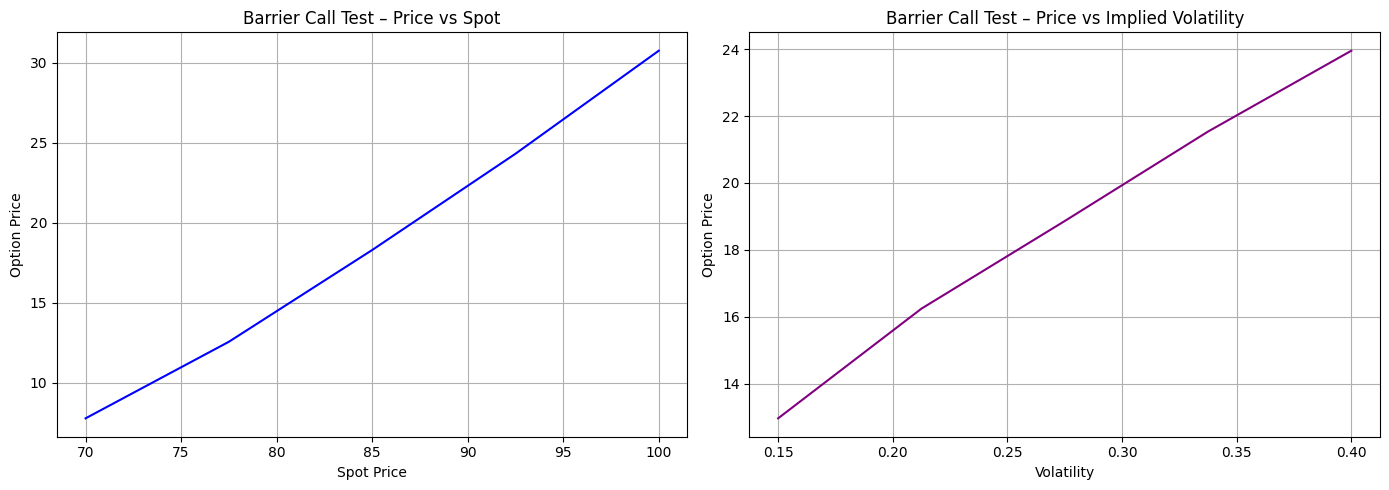

In [ ]:
# Graph for visualisation purposes. Option pricing conducts more simulations (10k, compared to the graph)

import visualise
importlib.reload(visualise)
from visualise import visualize_up_and_in_barrier_call

visualize_up_and_in_barrier_call(
    S0=spot_wes,
    K=strike_wes,
    T=expiry_wes,
    r=rate_wes,
    sigma=vol_wes,
    B=barrier_wes,
    M=100,
    steps=252
)

plot_spot_vol_sensitivity_barrier(
    label="Barrier Call Test",
    base_spot=spot_wes,
    base_vol=vol_wes,
    strike=strike_wes,
    expiry=expiry_wes,
    rate=rate_bhp,
    option_type="call",
    ticker=ticker_wes,
    barrier=100,
    spot_range=(70, 100, 5),
    vol_range=(0.15, 0.4, 5)
)

## Visualisation for the barrier call takes forever -- include????? (because of the simulations)



### Hedging Parameters

In [32]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_wes = hc.get_all_greeks(wes_option, method="fd")

print("Greeks for WES Option:")
for greek, value in greeks_wes.items():
    print(f"{greek}: {value}")

Greeks for WES Option:
delta: -12.182227419498126
gamma: 567.1677729493574
vega: 52.028120579093425
theta: -18.55093054186269
rho: 161.91761449893426


### Hedging Strategy

In [35]:
# Near-the-money barrier call (strike = spot)
strike_wes_ntmo = spot_wes
expiry_wes_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15))  # 2.33 Years
rate_wes_ntmo = yc.get_zero_rate(expiry_wes_ntmo)
wes_option_ntmo = UpAndInCallOption(
    ticker=ticker_wes,
    spot=spot_wes,
    strike=strike_wes_ntmo,
    expiry=expiry_wes_ntmo,
    rate=rate_wes_ntmo,
    vol=vol_wes,
    barrier=barrier_wes,
    simulations=10000,
    steps=252,
    dividend_yield=dividend_yield_wes
)

# Out-the-money barrier call (e.g. strike 10% above spot)
strike_wes_otmo = 1.10 * spot_wes
expiry_wes_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2027, 9, 15))  # 2.33 Years
rate_wes_otmo = yc.get_zero_rate(expiry_wes_otmo)
wes_option_otmo = UpAndInCallOption(
    ticker=ticker_wes,
    spot=spot_wes,
    strike=strike_wes_otmo,
    expiry=expiry_wes_otmo,
    rate=rate_wes_otmo,
    vol=vol_wes,
    barrier=barrier_wes,
    simulations=10000,
    steps=252,
    dividend_yield=dividend_yield_wes
)

# Short-term barrier call
strike_wes_st = spot_wes
expiry_wes_st = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 8, 15))  # 3 Months
rate_wes_st = yc.get_zero_rate(expiry_wes_st)
wes_option_st = UpAndInCallOption(
    ticker=ticker_wes,
    spot=spot_wes,
    strike=strike_wes_st,
    expiry=expiry_wes_st,
    rate=rate_wes_st,
    vol=vol_wes,
    barrier=barrier_wes,
    simulations=10000,
    steps=252,
    dividend_yield=dividend_yield_wes
)

# Calculate Greeks for hedges
delta_ntmo = hc.calculate_delta_fd(wes_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(wes_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(wes_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(wes_option_ntmo)

delta_otmo = hc.calculate_delta_fd(wes_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(wes_option_otmo)
vega_otmo = hc.calculate_vega_fd(wes_option_otmo)
rho_otmo = hc.calculate_rho_fd(wes_option_otmo)

delta_st = hc.calculate_delta_fd(wes_option_st)
gamma_st = hc.calculate_gamma_fd(wes_option_st)
vega_st = hc.calculate_vega_fd(wes_option_st)
rho_st = hc.calculate_rho_fd(wes_option_st)

hedges = {
    "Underlying Stock": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Barrier Call": {"Delta": delta_ntmo, "Gamma": gamma_ntmo, "Vega": vega_ntmo, "Rho": rho_ntmo},
    "Out-the-Money Barrier Call": {"Delta": delta_otmo, "Gamma": gamma_otmo, "Vega": vega_otmo, "Rho": rho_otmo},
    "Short-Term Barrier Call": {"Delta": delta_st, "Gamma": gamma_st, "Vega": vega_st, "Rho": rho_st},
}

hedge_matrix = pd.DataFrame(hedges).T
print("Hedge Matrix:")
print(hedge_matrix)

# Calculate Greeks of barrier option
delta = hc.calculate_delta_fd(wes_option)
gamma = hc.calculate_gamma_fd(wes_option)
vega = hc.calculate_vega_fd(wes_option)
rho = hc.calculate_rho_fd(wes_option)

wes_greeks = np.array([delta, gamma, vega, rho])

# Optimization
def objective(weights):
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + wes_greeks)

initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)
result = minimize(objective, initial_weights)
optimal_weights = result.x

hedge_allocations = pd.DataFrame({
    "Instrument": hedge_matrix.index,
    "Optimal Weight": optimal_weights
})

print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

minimized_greeks = hedge_matrix.values.T @ optimal_weights + wes_greeks
greek_names = ["Delta", "Gamma", "Vega", "Rho"]

greek_matrix = pd.DataFrame({
    "Original WES Barrier Option": wes_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                                 Delta        Gamma       Vega          Rho
Underlying Stock              1.000000     0.000000   0.000000     0.000000
Near-the-Money Barrier Call  19.219020 -1132.087723  33.557885  1194.433943
Out-the-Money Barrier Call   -3.050557 -9868.630291  43.704922   603.603375
Short-Term Barrier Call       0.555679  1330.596933  23.867968   613.198265

Optimal Hedge Allocations:
                    Instrument  Optimal Weight
0             Underlying Stock         -2.5328
1  Near-the-Money Barrier Call          0.0912
2   Out-the-Money Barrier Call         -0.3315
3      Short-Term Barrier Call         -1.5945

Greek Neutralization Result:
       Original WES Barrier Option  Post-Hedging (Minimized)
Delta                       0.6509                   -0.0044
Gamma                   -1046.7205                    0.0009
Vega                       49.4808                   -0.0070
Rho                      1068.9766                    0.0034


### Design and Model Justification

## Trade 4: Basket Call

description of the trade

### Market Data

In [36]:
# Basket Call Option Inputs
tickers_basket = ["BHP.AX", "CSL.AX", "WDS.AX", "MQG.AX"]
date = "2025-05-16"
spot = {ticker: get_close_price(ticker, date) for ticker in tickers_basket}
vol = {ticker: get_volatility(ticker, end_date=date, window=60) for ticker in tickers_basket}
spot_basket = [spot[t] for t in tickers_basket]
vol_basket = [vol[t] for t in tickers_basket]
basket_corr = get_correlation_matrix(tickers_basket, window=60, end_date=date)
weights = [0.10, 0.35, 0.15, 0.40]
strike_basket = 175.0

from datetime import datetime
expiry_basket = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))

print("Spot prices:", spot_basket)
print("Volatilities:", vol_basket)
print(f"Strike: {strike_basket}, Expiry: {expiry_basket:.2f} yrs")
print(basket_corr)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Spot prices: [39.720001220703125, 241.82000732421875, 21.920000076293945, 207.35000610351562]
Volatilities: [0.2960193441890185, 0.2645795058608444, 0.40561362662594136, 0.3774390594028384]
Strike: 175.0, Expiry: 0.17 yrs
Ticker    BHP.AX    CSL.AX    MQG.AX    WDS.AX
Ticker                                        
BHP.AX  1.000000  0.460959  0.447800  0.583995
CSL.AX  0.460959  1.000000  0.450133  0.407607
MQG.AX  0.447800  0.450133  1.000000  0.647139
WDS.AX  0.583995  0.407607  0.647139  1.000000


### Discount Rate

In [86]:
rate_basket = yc.get_zero_rate(expiry_basket)
print(f"Discount Rate for Basket Option: {rate_basket:.4%}")

Discount Rate for Basket Option: 3.7980%


### Valuation

In [39]:
# Instantiate and price the option 
dividend_yield_basket = 0.044268  #weighted average of asset div yields taken from Bloomberg
basket_option = BasketCallOption(tickers=tickers_basket, spot_prices=spot_basket, weights=weights, strike=strike_basket, expiry=expiry_basket, rate=rate_basket, vol=vol_basket, corr_matrix=basket_corr, dividend_yield=dividend_yield_basket)
print(f"Basket Option Price: {basket_option.price()}")

Basket Option Price: 7.575137143091325


### Visualisation

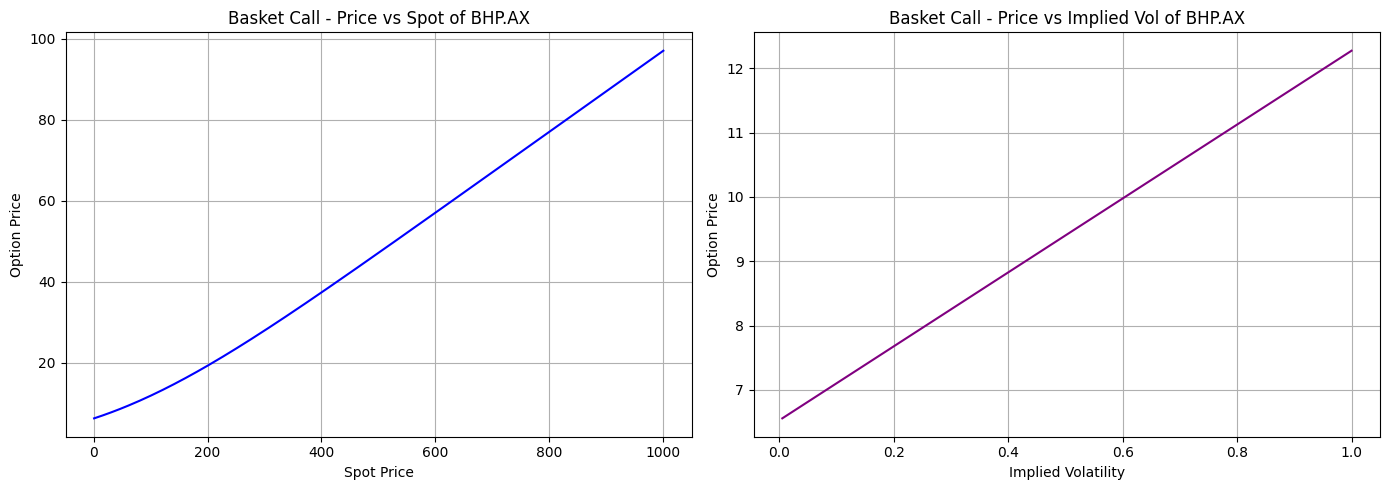

In [40]:
plot_spot_vol_sensitivity_basket_bs(
    label="Basket Call",
    base_spots=spot_basket,
    base_vols=vol_basket,
    weights=weights,
    corr_matrix=basket_corr,
    strike=strike_basket,
    expiry=expiry_basket,
    rate=rate_basket,
    ticker="Basket",
    tickers=tickers_basket,
    component_index=0, # 0 = BHP, 1 = CSL, 2 = WDS, 3 = MQG
    spot_range=(1, 1000, 200),
    vol_range=(0.005, 1, 40),
    option_class=BasketCallOption
)


### Hedging Parameters

In [41]:
# Use HedgingCalculator to get delta, gamma, vega, theta, rho
hc = HedgingCalculator()
greeks_basket = hc.get_all_greeks(basket_option, method="fd")

print("Greeks for Basket Option:")
for greek, value in greeks_basket.items():
    print(f"{greek}: {value}")

Greeks for Basket Option:
delta: [np.float64(0.05113173909592206), np.float64(0.1789610867326985), np.float64(0.07669760863890929), np.float64(0.20452695622736883)]
gamma: [np.float64(0.00020230913833074737), np.float64(0.0024782853813576367), np.float64(0.00045519541913563444), np.float64(0.003236944223772298)]
vega: [np.float64(1.9717345028865907), np.float64(7.1755145534368125), np.float64(3.3638314553158466), np.float64(10.310376763631979)]
theta: 22.066803487612447
rho: 13.89854240102295


### Hedging Strategy

In [43]:
# Near-the-money basket call
strike_basket_ntmo = np.dot(spot_basket, weights)
expiry_basket_ntmo = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))  # 2 Months
rate_basket_ntmo = yc.get_zero_rate(expiry_basket_ntmo)
basket_option_ntmo = BasketCallOption(
    tickers=tickers_basket,
    spot_prices=spot_basket,
    weights=weights,
    strike=strike_basket_ntmo,
    expiry=expiry_basket_ntmo,
    rate=rate_basket_ntmo,
    vol=vol_basket,
    corr_matrix=basket_corr,
    dividend_yield=dividend_yield_basket
)

# Out-the-money basket call
strike_basket_otmo = 1.10 * np.dot(spot_basket, weights)
expiry_basket_otmo = time_to_expiry(datetime(2025, 5, 16), datetime(2025, 7, 17))  # 2 Months
rate_basket_otmo = yc.get_zero_rate(expiry_basket_otmo)
basket_option_otmo = BasketCallOption(
    tickers=tickers_basket,
    spot_prices=spot_basket,
    weights=weights,
    strike=strike_basket_otmo,
    expiry=expiry_basket_otmo,
    rate=rate_basket_otmo,
    vol=vol_basket,
    corr_matrix=basket_corr,
    dividend_yield=dividend_yield_basket
)

# Long-term basket call
strike_basket_lt = np.dot(spot_basket, weights)
expiry_basket_lt = time_to_expiry(datetime(2025, 5, 16), datetime(2026, 5, 15))  # 1 Year
rate_basket_lt = yc.get_zero_rate(expiry_basket_lt)
basket_option_lt = BasketCallOption(
    tickers=tickers_basket,
    spot_prices=spot_basket,
    weights=weights,
    strike=strike_basket_lt,
    expiry=expiry_basket_lt,
    rate=rate_basket_lt,
    vol=vol_basket,
    corr_matrix=basket_corr,
    dividend_yield=dividend_yield_basket
)

# Calculate Greeks for hedging instruments
delta_ntmo = hc.calculate_delta_fd(basket_option_ntmo)
gamma_ntmo = hc.calculate_gamma_fd(basket_option_ntmo)
vega_ntmo = hc.calculate_vega_fd(basket_option_ntmo)
rho_ntmo = hc.calculate_rho_fd(basket_option_ntmo)

delta_otmo = hc.calculate_delta_fd(basket_option_otmo)
gamma_otmo = hc.calculate_gamma_fd(basket_option_otmo)
vega_otmo = hc.calculate_vega_fd(basket_option_otmo)
rho_otmo = hc.calculate_rho_fd(basket_option_otmo)

delta_lt = hc.calculate_delta_fd(basket_option_lt)
gamma_lt = hc.calculate_gamma_fd(basket_option_lt)
vega_lt = hc.calculate_vega_fd(basket_option_lt)
rho_lt = hc.calculate_rho_fd(basket_option_lt)

# Build hedge matrix
hedges = {
    "Underlying Basket": {"Delta": 1, "Gamma": 0, "Vega": 0, "Rho": 0},
    "Near-the-Money Basket Call": {"Delta": np.dot(delta_ntmo, weights), "Gamma": np.dot(gamma_ntmo, weights), "Vega": np.dot(vega_ntmo, weights), "Rho": rho_ntmo},
    "Out-the-Money Basket Call": {"Delta": np.dot(delta_otmo, weights), "Gamma": np.dot(gamma_otmo, weights), "Vega": np.dot(vega_otmo, weights), "Rho": rho_otmo},
    "Long-Term Basket Call": {"Delta": np.dot(delta_lt, weights), "Gamma": np.dot(gamma_lt, weights), "Vega": np.dot(vega_lt, weights), "Rho": rho_lt},
}

hedge_matrix = pd.DataFrame(hedges).T
print("Hedge Matrix:")
print(hedge_matrix)

# Calculate Greeks of the basket option
delta = hc.calculate_delta_fd(basket_option)
gamma = hc.calculate_gamma_fd(basket_option)
vega = hc.calculate_vega_fd(basket_option)
rho = hc.calculate_rho_fd(basket_option)

# Convert vector Greeks to scalars using basket weights
delta = np.dot(delta, weights)
gamma = np.dot(gamma, weights)
vega = np.dot(vega, weights)

basket_greeks = np.array([delta, gamma, vega, rho], dtype=float)

# Optimization
def objective(weights):
    weights = np.array(weights)
    hedge_effect = hedge_matrix.values.T @ weights
    return np.linalg.norm(hedge_effect + basket_greeks)

initial_weights = np.ones(len(hedge_matrix)) / len(hedge_matrix)
result = minimize(objective, initial_weights)
optimal_weights = result.x

hedge_allocations = pd.DataFrame({
    "Instrument": hedge_matrix.index,
    "Optimal Weight": optimal_weights
})

print("\nOptimal Hedge Allocations:")
print(hedge_allocations.round(4))

minimized_greeks = hedge_matrix.values.T @ optimal_weights + basket_greeks
greek_names = ["Delta", "Gamma", "Vega", "Rho"]

greek_matrix = pd.DataFrame({
    "Original Basket Call Option": basket_greeks,
    "Post-Hedging (Minimized)": minimized_greeks
}, index=greek_names)

print("\nGreek Neutralization Result:")
print(greek_matrix.round(4))

Hedge Matrix:
                               Delta     Gamma       Vega        Rho
Underlying Basket           1.000000  0.000000   0.000000   0.000000
Near-the-Money Basket Call  0.162103  0.002250   7.334749  13.983421
Out-the-Money Basket Call   0.065724  0.001628   5.307611   5.824159
Long-Term Basket Call       0.158932  0.000894  17.111182  71.310701

Optimal Hedge Allocations:
                   Instrument  Optimal Weight
0           Underlying Basket         -0.0350
1  Near-the-Money Basket Call         -0.5315
2   Out-the-Money Basket Call         -0.4827
3       Long-Term Basket Call         -0.0513

Greek Neutralization Result:
       Original Basket Call Option  Post-Hedging (Minimized)
Delta                       0.1611                    0.0000
Gamma                       0.0023                    0.0002
Vega                        7.3373                   -0.0000
Rho                        13.8985                   -0.0000


### Design and Model Justification (might remove)

## Portfolio Valuation and Hedging Summary (might remove)

In [28]:
# Collect all option prices and Greek exposures into summary DataFrame
# Sum portfolio value and Greek sensitivities

## Design and Model Justification (might remove)

- Why Black-Scholes, Binomial Tree, and Monte Carlo were chosen
- Why finite difference for Greeks
- Why the bump sizes used
- Accuracy vs flexibility trade-offs

## Conclusion

- Modular, OOP-driven pricing system
- Accurate pricing and hedging of diverse OTC trades
- Integration of real market data and theory